In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import time

plt.rc('font',family='Times New Roman')

import GPy
import GPyOpt

from math import *

In [2]:
%matplotlib inline

In [6]:
def f(action, current_state):
    current_state = 10*(np.sin(action)) + current_state
    
    return current_state

In [7]:
#linear policy
def action_from_policy(policyParameters, current_state):
    action = 0
    [r,c] = policyParameters.shape
    for i in range(c):
        if i < c-1:
            action = action + (policyParameters[0,i]*current_state[0,i])
        else:
            action = action + policyParameters[0,i]
    
    action = np.pi * ((9/8)*np.sin(action) + (1/8)*np.sin(3*action))
    
    return action            

In [16]:
def objective_function(policyParameters):
    
    global goal
    global m
    global total_count
    
    total_reward = 0
    goal_counter = 0
    counter = 0
    
    current_state = np.array([[0]])
    state_evolution = current_state
    error_evolution = current_state
    
    action = action_from_policy(policyParameters, current_state)
    
    model_input = np.array([action, current_state])
    model_input = np.reshape(model_input, ([1,2]))
    
    while goal_counter < 30 and counter < 300:
        
        current_state = m.predict(model_input)[0]
        
        current_state = np.reshape(current_state, ([1,1]))
        state_evolution = np.append(state_evolution, current_state, axis = 0)
        
        buffer_reward = abs(goal - current_state[0,0])
        
        total_reward = total_reward + buffer_reward
        
        if buffer_reward < 10:
            goal_counter += 1
            
        action = action_from_policy(policyParameters, current_state)
        model_input = np.array([action, current_state])
        model_input = np.reshape(model_input, ([1,2]))
        
        counter += 1
        
    total_count += 1
        
    print goal_counter, counter, total_count, buffer_reward
    if buffer_reward < 5:
        plt.plot(state_evolution)
        
    return total_reward

In [11]:
total_it = 1000
current_state = np.random.uniform(-pi,pi,1)
state_evolution = np.zeros((total_it,1))#, dtype='int64')
# input_states = np.zeros((total_it,2))#, dtype='int64')
# output_states = np.zeros((total_it,1))#, dtype='int64')
prediction_evolution = np.zeros((total_it,1))#, dtype='int64')
k = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)

for i in range(total_it):

    if i%50 == 0:
        print i
    action = np.random.uniform(-pi, pi, 1)

    # state_evolution[i] = current_state
    bufferInput = np.array([action,current_state])
    bufferInput = np.reshape(bufferInput, ([1, 2]))

    if i > 0:
        input_states = np.append(input_states, bufferInput, axis = 0)
    else:
        input_states = bufferInput

    current_state = f(action, current_state)
    bufferState = np.reshape(current_state, ([1,1]))
    if i > 0:
        output_states = np.append(output_states, bufferState, axis=0)
    else:
        output_states = bufferState

    if i > 0:
        # time.sleep(0.2)
        prediction = m.predict(bufferInput)[0]
        # print prediction
        prediction_evolution[i,0] = prediction

    m = GPy.models.GPRegression(input_states, output_states, k)
    m.optimize()

    action = np.random.uniform(-pi, pi, 1)
print total_it

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


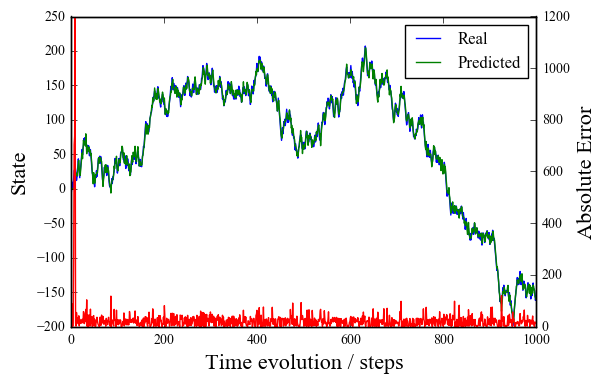

In [12]:
m_test = m
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(output_states[00:])
ax1.plot(prediction_evolution[00:])
ax2.plot(((np.abs(prediction_evolution[00:]-output_states[00:]))*(np.abs(prediction_evolution[00:]-output_states[00:]))),  'r')

ax1.legend(['Real', 'Predicted'], loc='upper right')
ax1.set_xlabel('Time evolution / steps', fontsize=16)
ax1.set_ylabel('State', fontsize=16)
ax2.set_ylabel('Absolute Error', fontsize=16)
#pylab.savefig('./stateEvolution.eps', format='eps')
plt.show()

In [14]:
bounds = [{'domain': (-1,1), 'name': 'var_1', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-10,10), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1}]

0 300 1 100.215378957
0 300 2 264.638752873
0 300 3 96.3290090581
0 300 4 179.931812221
0 300 5 114.962835132
0 300 6 100.2153793
0 300 7 100.098881821
0 300 8 100.296881611
0 300 9 96.6540157542
0 300 10 101.305059436
0 300 11 96.6714501358
0 300 12 97.2721798277
0 300 13 99.8102453068
0 300 14 98.2279628231
0 300 15 93.5724661199
0 300 16 82.0055285635
2 300 17 155.370014445
0 300 18 87.6515833924
0 300 19 77.1162695716
0 300 20 112.02108266
0 300 21 76.0866226229
0 300 22 78.0217028388
0 300 23 44.024132077
0 300 24 191.341129189
30 227 25 1.82021780591
0 300 26 26.9635584606
0 300 27 171.401868381
0 300 28 106.479272525
0 300 29 124.59494091
0 300 30 111.898819657
15 300 31 6.57696593076
0 300 32 89.1281546707
0 300 33 63.328632429
0 300 34 260.950270978
0 300 35 85.6313756498
0 300 36 36.4798329393
0 300 37 45.0900672718
0 300 38 94.5776406022
0 300 39 258.751975134
0 300 40 87.1526919416
0 300 41 98.3778367861
0 300 42 79.2361939838
0 300 43 38.0691135646
0 300 44 90.4802536267
3

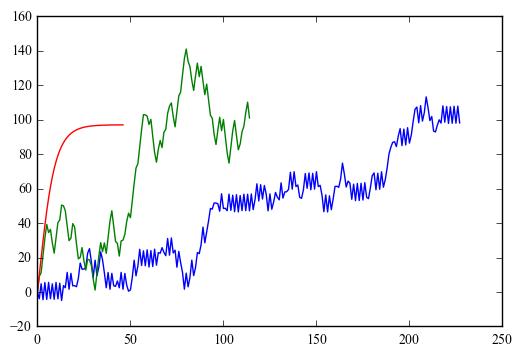

In [17]:
total_count = 0
goal = 100
myBopt = GPyOpt.methods.BayesianOptimization(f = objective_function, domain = bounds, acquisition_type ='MPI', num_cores=4, verbosity=True)
max_iter = 200              # evaluation budget
myBopt.run_optimization(max_iter) 

In [24]:
policyParameters = myBopt.X[np.argmin(myBopt.Y)]
policyParameters = np.reshape(policyParameters, ([1,2]))
print policyParameters, np.argmin(myBopt.Y)

[[-0.01664583  1.60914283]] 130


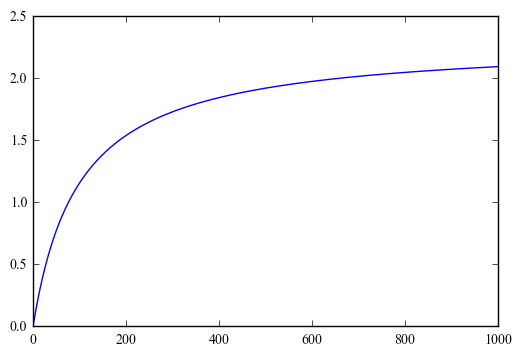

In [25]:
currentState = np.array([[0]])
bufferCurrentState = currentState
action = action_from_policy(policyParameters, currentState)

bufferInput_policy = np.array([action,bufferCurrentState])
bufferInput_policy = np.reshape(bufferInput_policy, ([1, 2]))
for i in range(1000):
    bufferCurrentState = f(action, bufferCurrentState)
    #bufferCurrentState = m.predict(bufferInput_policy)[0]
    bufferCurrentState = np.reshape(bufferCurrentState, ([1,1]))

    currentState = np.append(currentState,bufferCurrentState, axis = 0)
    
    action = action_from_policy(policyParameters, bufferCurrentState)
    bufferInput_policy = np.array([action,bufferCurrentState])
    bufferInput_policy = np.reshape(bufferInput_policy, ([1, 2]))

plt.plot(currentState)

30 46 207 2.958089869


738.24171060125809

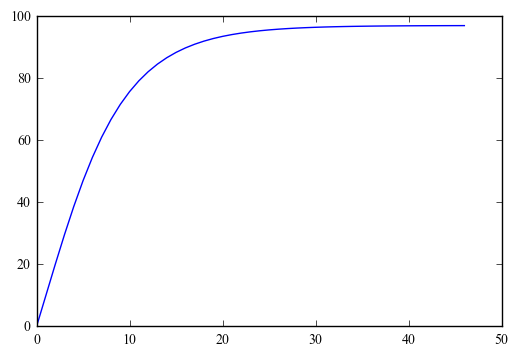

In [26]:
objective_function(policyParameters)